In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('mode.chained_assignment',  None)

SMART_CARD = pd.read_csv('./data/SMART_CARD.csv')

# getrouteinfoall
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0)
getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]

### gestationbyrouteall
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0)

In [2]:
def smart_card_preprocessing(exdata): # 스마트카드 데이터 전처리
    exdata.columns = ['SERIAL_NO', 'CARD_NO', 'GETON_YMD', 'GETON_TM', 'BUS_ROUTE_ID', 'BUS_CO_ID', 'BUS_CAR_ID', 'GETON_BUS_STTN_ID', 'GETOFF_BUS_STTN_ID',
                      'DRVR_ID', 'TRANSACTION_ID', 'TR_MEANS_TYPE', 'USR_TYPE', 'DRVN_START_YMD', 'DRVN_START_TM', 'GETOFF_YMD', 'GETOFF_TM', 'GETON_CALC_YMD',
                      'GETOFF_CALC_YMD', 'GETON_PAY', 'GETOFF_PAY', 'TRANSF_CNT', 'USR_CNT']
    
    exdata = exdata[exdata['GETOFF_BUS_STTN_ID']!='~      '] # 하차 태그 없는 데이터 제거
    
    # 601,704, 912,117,701만, 203,613,511 추출
    exdata = exdata[exdata['BUS_ROUTE_ID'].isin([30300068,30300088,30300145,30300108,30300086,30300131,30300077,30300064])]
    
    # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기
    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6))
    exdata['DRVN_START_TM'] = exdata['DRVN_START_TM'].apply(lambda x: str(x).zfill(6))
        
    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')
    exdata['GETOFF_DATETIME'] = pd.to_datetime(exdata['GETOFF_YMD'].astype(str) + exdata['GETOFF_TM'].astype(str), format = '%Y%m%d%H%M%S')
    exdata['DRVN_START_DATETIME'] = pd.to_datetime(exdata['DRVN_START_YMD'].astype(str) + exdata['DRVN_START_TM'].astype(str), format = '%Y%m%d%H%M%S')
    
    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day
    exdata['WEEKDAY'] = exdata['GETON_DATETIME'].dt.weekday  
    exdata['GETON_HOUR'] = exdata['GETON_DATETIME'].dt.hour

    # 평일만 추출
    weekday_values = [0, 1, 2, 3, 4]
    exdata = exdata[exdata['WEEKDAY'].isin(weekday_values)]

    # 6/6일 제거
    exdata = exdata[exdata['DAY'] != 6]
    
    # 비가 온 날 제거
    # exdata = exdata[~exdata['DAY'].isin([26,29])]
    
    # int형으로 변환
    exdata['GETOFF_BUS_STTN_ID'] = exdata['GETOFF_BUS_STTN_ID'].astype(int)
    
    # # 여러명이 탄 경우 제거
    # exdata = exdata[exdata['USR_CNT']==1]
    
    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','GETOFF_YMD','GETOFF_TM','DRVN_START_YMD','DRVN_START_TM'], axis = 1, inplace = True)

    # 필요없는 행 제거
    exdata.drop(labels = ['SERIAL_NO', 'DRVR_ID','GETON_PAY','GETOFF_PAY','USR_TYPE','GETON_CALC_YMD', 'GETOFF_CALC_YMD', 'TRANSACTION_ID','TR_MEANS_TYPE','WEEKDAY'], axis = 1, inplace = True)
    
    # exdata = exdata[['CARD_NO','BUS_ROUTE_ID', 'TR_MEANS_TYPE', 'GETON_BUS_STTN_ID', 'GETON_DATETIME', 'GETOFF_BUS_STTN_ID', 'GETOFF_DATETIME','DAY']]
    return exdata

In [3]:
SMART_CARD_DATA = smart_card_preprocessing(SMART_CARD)
SMART_CARD_DATA_MERGE = SMART_CARD_DATA.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
SMART_CARD_DATA_MERGE = SMART_CARD_DATA_MERGE[['CARD_NO','ROUTE_NO','ROUTE_CD','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME','DRVN_START_DATETIME','TRANSF_CNT','USR_CNT','DAY','GETON_HOUR']]
SMART_CARD_DATA_MERGE.head(2)

,CARD_NO,ROUTE_NO,ROUTE_CD,BUS_CO_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,GETOFF_BUS_STTN_ID,GETOFF_DATETIME,DRVN_START_DATETIME,TRANSF_CNT,USR_CNT,DAY,GETON_HOUR
0,1113203560,701,30300086,130010013,130759808,8001479,2023-06-01 05:35:56,8002464,2023-06-01 05:52:28,2023-06-01 05:34:13,199,1,1,5
1,917822127,701,30300086,130010013,130759808,8001479,2023-06-01 05:36:25,8001430,2023-06-01 05:53:32,2023-06-01 05:34:13,199,1,1,5


In [4]:
# 601번만 필터링
BUS_601 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='601']

# 704번만 필터링
BUS_704 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='704']

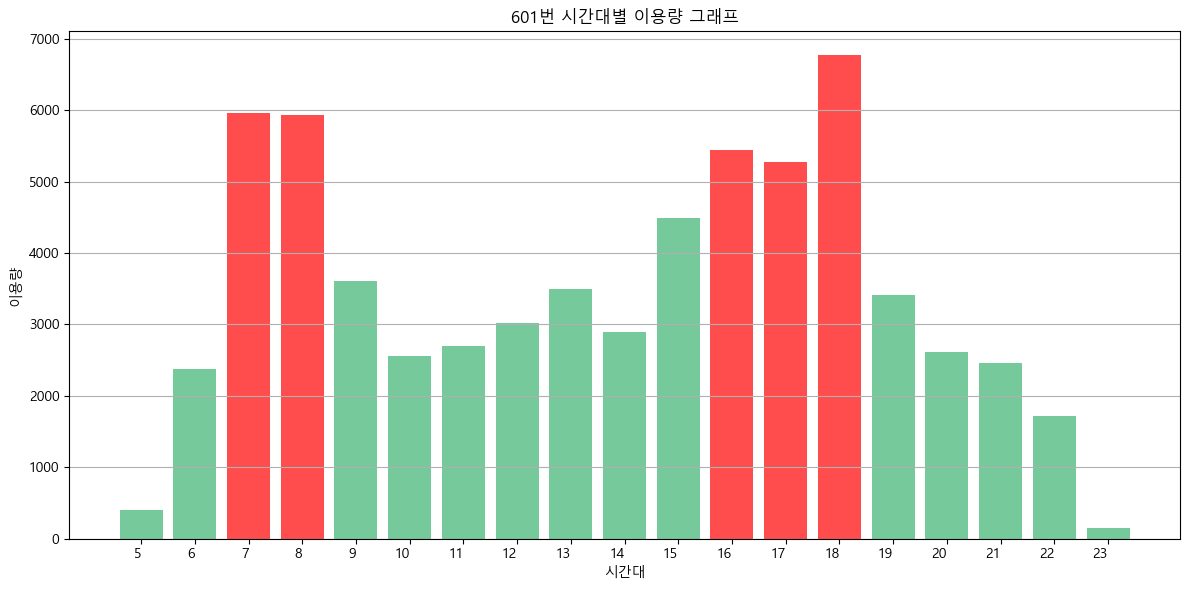

In [5]:
import matplotlib.pyplot as plt

# GETON_HOUR 열을 기준으로 데이터를 그룹화하고 SIZE를 계산
hourly_counts = BUS_601.groupby('GETON_HOUR').size()

# 상위 5개 항목을 선택하여 빨간색으로 표시
top_5_hours = hourly_counts.nlargest(5)
top_5_labels = top_5_hours.index

# 그래프 생성
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(12, 6))
colors = ['mediumseagreen' if hour not in top_5_labels else 'red' for hour in hourly_counts.index]
plt.bar(hourly_counts.index, hourly_counts, color=colors, alpha=0.7)
plt.title('601번 시간대별 이용량 그래프')
plt.xlabel('시간대')
plt.ylabel('이용량')

# X 축 레이블 모두 표시
plt.xticks(hourly_counts.index, rotation=0, ha='right')

plt.grid(axis='y')

# 그래프 표시
plt.tight_layout()
plt.show()


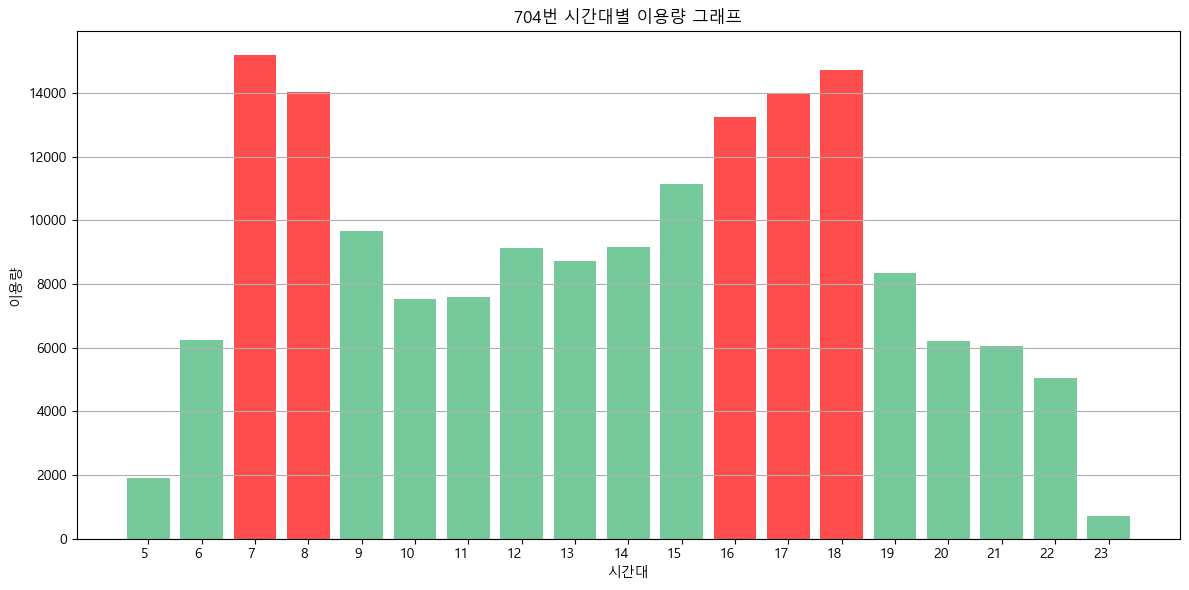

In [6]:
import matplotlib.pyplot as plt

# GETON_HOUR 열을 기준으로 데이터를 그룹화하고 SIZE를 계산
hourly_counts = BUS_704.groupby('GETON_HOUR').size()

# 상위 5개 항목을 선택하여 빨간색으로 표시
top_5_hours = hourly_counts.nlargest(5)
top_5_labels = top_5_hours.index

# 그래프 생성
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(12, 6))
colors = ['mediumseagreen' if hour not in top_5_labels else 'red' for hour in hourly_counts.index]
plt.bar(hourly_counts.index, hourly_counts, color=colors, alpha=0.7)
plt.title('704번 시간대별 이용량 그래프')
plt.xlabel('시간대')
plt.ylabel('이용량')

# X 축 레이블 모두 표시
plt.xticks(hourly_counts.index, rotation=0, ha='right')

plt.grid(axis='y')

# 그래프 표시
plt.tight_layout()
plt.show()


---

In [7]:
day_values = [1, 2, 5, 7, 8, 9, 12, 13, 14, 15, 16, 20, 21, 22, 23, 27, 28, 30]

def get_date_df1(exdata, date):
    exdata = exdata[exdata['DAY']==date]
    exdata = exdata[exdata['GETON_HOUR'].isin([7,8])]
    exdata['DRVN_START_HOUR'] = exdata['DRVN_START_DATETIME'].dt.hour
    return exdata

def get_date_df2(exdata, date):
    exdata = exdata[exdata['DAY']==date]
    exdata = exdata[exdata['GETON_HOUR'].isin([16,17,18])]
    exdata['DRVN_START_HOUR'] = exdata['DRVN_START_DATETIME'].dt.hour
    return exdata

In [8]:
for date in day_values:
    df_name = f'BUS_601_{date}_morning'
    globals()[df_name] = get_date_df1(BUS_601, date)
    
for date in day_values:
    df_name = f'BUS_601_{date}_night'
    globals()[df_name] = get_date_df2(BUS_601, date)

601번

In [9]:
BUS_601_morning = BUS_601[BUS_601['GETON_HOUR'].isin([7,8])]
BUS_601_morning['DRVN_START_HOUR'] = BUS_601_morning['DRVN_START_DATETIME'].dt.hour
BUS_601_morning['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
7    5060
6    3730
8    1580
5    1491
4      43
Name: count, dtype: int64

In [10]:
BUS_601_night = BUS_601[BUS_601['GETON_HOUR'].isin([16,17,18])]
BUS_601_night['DRVN_START_HOUR'] = BUS_601_night['DRVN_START_DATETIME'].dt.hour
BUS_601_night['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
16    5279
17    4107
15    3653
18    2008
14    1603
13     331
12     297
11     128
10      75
Name: count, dtype: int64

704번

In [11]:
BUS_704_morning = BUS_704[BUS_704['GETON_HOUR'].isin([7,8])]
BUS_704_morning['DRVN_START_HOUR'] = BUS_704_morning['DRVN_START_DATETIME'].dt.hour
BUS_704_morning['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
7     12554
6     10060
8      3862
5      2720
22        6
Name: count, dtype: int64

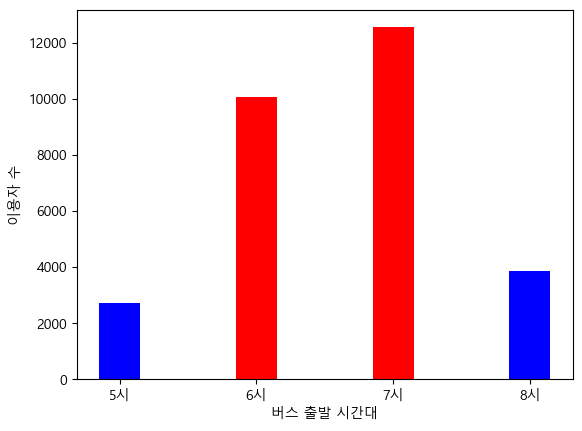

In [12]:
import matplotlib.pyplot as plt

# 데이터
hours = [5, 6, 7, 8]
users = [2720, 10060, 12554, 3862]

# 색상 설정
colors = ['blue', 'red', 'red', 'blue']

# 막대 폭 설정
bar_width = 0.3  # 막대 폭을 조정할 값

# 그래프 생성
plt.bar(hours, users, color=colors, width = bar_width)
plt.xlabel('버스 출발 시간대')
plt.ylabel('이용자 수')


# x축 레이블 설정
plt.xticks(hours, labels=[ '5시', '6시', '7시', '8시'])

# 그래프 표시
plt.show()


In [18]:
BUS_601['DRVN_START_HOUR'] = BUS_601['DRVN_START_DATETIME'].dt.hour
BUS_601['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
7     6018
16    5644
15    5225
6     5046
17    4744
14    4608
13    3579
12    3496
18    3484
11    3386
9     3369
8     3344
5     3264
19    2709
10    2672
20    2474
21    1390
22     724
4       74
Name: count, dtype: int64

In [19]:
BUS_704['DRVN_START_HOUR'] = BUS_704['DRVN_START_DATETIME'].dt.hour
BUS_704['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
6     15021
7     14568
16    13735
15    13382
17    12817
14    12705
12     9936
13     9849
8      9288
5      8628
11     8127
9      8099
10     7607
18     7570
19     5742
20     5577
21     4485
22     1425
Name: count, dtype: int64

In [20]:
BUS_704_night = BUS_704[BUS_704['GETON_HOUR'].isin([16,17,18])]
BUS_704_night['DRVN_START_HOUR'] = BUS_704_night['DRVN_START_DATETIME'].dt.hour
BUS_704_night['DRVN_START_HOUR'].value_counts()

DRVN_START_HOUR
16    12899
17    10791
15     9961
14     3890
18     2707
13     1316
12      345
11       46
Name: count, dtype: int64

대기시간 비용 구하기

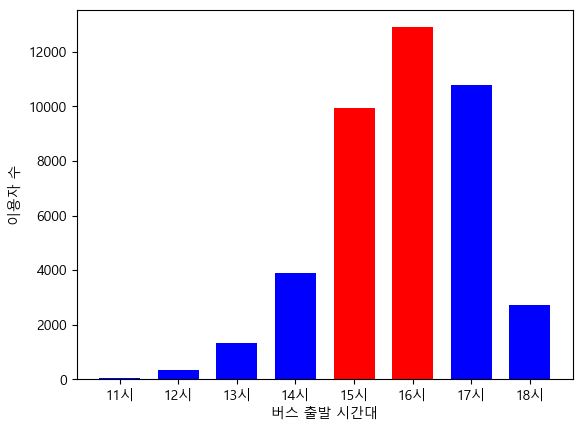

In [21]:
import matplotlib.pyplot as plt

# 데이터
hours = list(range(11,19))
users = [46, 345, 1316, 3890,9961,12899,10791,2707]

# 색상 설정
colors = ['blue','blue','blue','blue', 'red', 'red', 'blue']
plt.rc('font',family='malgun gothic')

# 막대 폭 설정
bar_width = 0.7  # 막대 폭을 조정할 값

# 그래프 생성
plt.bar(hours, users, color=colors, width = bar_width)
plt.xlabel('버스 출발 시간대')
plt.ylabel('이용자 수')

# x축 레이블 설정
plt.xticks(hours, labels = ['11시', '12시', '13시', '14시', '15시', '16시', '17시','18시'])

# 그래프 표시
plt.show()


In [22]:
from datetime import datetime

getrouteinfoall_df2 = getrouteinfoall[['ROUTE_NO', 'ALLO_INTERVAL','ORIGIN_START','ORIGIN_END','TURN_START','TURN_END']]
getrouteinfoall_df2 = getrouteinfoall_df2[getrouteinfoall_df2['ROUTE_NO'].isin(['601','704','912','117','701','203','613','511'])]

# 앞에 0을 추가하여 시간 타입으로 바꿀 수 있도록 함
getrouteinfoall_df2['ORIGIN_START'] = getrouteinfoall_df2['ORIGIN_START'].apply(lambda x: str(x).zfill(4))
getrouteinfoall_df2['TURN_START'] = getrouteinfoall_df2['TURN_START'].apply(lambda x: str(x).zfill(4))

# 시간 형식으로 변환
getrouteinfoall_df2['ORIGIN_START'] = pd.to_datetime(getrouteinfoall_df2['ORIGIN_START'], format = '%H%M')
getrouteinfoall_df2['ORIGIN_END'] = pd.to_datetime(getrouteinfoall_df2['ORIGIN_END'], format='%H%M')
getrouteinfoall_df2['TURN_START'] = pd.to_datetime(getrouteinfoall_df2['TURN_START'], format='%H%M')
getrouteinfoall_df2['TURN_END'] = pd.to_datetime(getrouteinfoall_df2['TURN_END'], format='%H%M')

# ORIGIN_TIME_DIFF와 TURN_TIME_DIFF 열 생성
getrouteinfoall_df2['ORIGIN_TIME_DIFF'] = (getrouteinfoall_df2['ORIGIN_END'] - getrouteinfoall_df2['ORIGIN_START']).dt.total_seconds() / 60
getrouteinfoall_df2['TURN_TIME_DIFF'] = (getrouteinfoall_df2['TURN_END'] - getrouteinfoall_df2['TURN_START']).dt.total_seconds() / 60

# 정수로 변환
getrouteinfoall_df2['ORIGIN_TIME_DIFF'] = getrouteinfoall_df2['ORIGIN_TIME_DIFF'].astype(int)
getrouteinfoall_df2['TURN_TIME_DIFF'] = getrouteinfoall_df2['TURN_TIME_DIFF'].astype(int)

# 이용 대수 계산
getrouteinfoall_df2['ALLO_INTERVAL'] = getrouteinfoall_df2['ALLO_INTERVAL'].astype(int)
getrouteinfoall_df2['ORIGIN_BUS_CNT'] = getrouteinfoall_df2['ORIGIN_TIME_DIFF'] // getrouteinfoall_df2['ALLO_INTERVAL']
getrouteinfoall_df2['TURN_BUS_CNT'] = getrouteinfoall_df2['TURN_TIME_DIFF'] // getrouteinfoall_df2['ALLO_INTERVAL']
getrouteinfoall_df2['TOTAL_BUS_CNT'] = getrouteinfoall_df2['ORIGIN_BUS_CNT'] + getrouteinfoall_df2['TURN_BUS_CNT']
getrouteinfoall_df2['TOTAL_BUS_CNT_WORK'] = ((300 / getrouteinfoall_df2['ALLO_INTERVAL'])*2).astype(int)

# 사용한 행 제거
getrouteinfoall_df2.drop(labels = ['ORIGIN_START','ORIGIN_END','TURN_START','TURN_END', 'ORIGIN_BUS_CNT','TURN_BUS_CNT'], axis = 1, inplace = True)

getrouteinfoall_df2.head(2)

,ROUTE_NO,ALLO_INTERVAL,ORIGIN_TIME_DIFF,TURN_TIME_DIFF,TOTAL_BUS_CNT,TOTAL_BUS_CNT_WORK
54,511,13,1030,1050,159,46
58,601,21,1020,1020,96,28


In [23]:
# 버스데이터에 배차간격 추가
def plus_allo_interval(exdata,getrouteinfoall_df2):
    exdata = exdata.merge(getrouteinfoall_df2, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
    exdata.drop(labels = ['ROUTE_CD','BUS_CO_ID','TRANSF_CNT','USR_CNT','DAY'], axis = 1, inplace = True)
    return exdata

def cal_waiting_time_1(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata[exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])]) + allo_interval / 2 * len(exdata[~exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])]) # 기존 배차간격의 대기시간 비용 합
    wating_time = (allo_interval - minute) / 2 * len(exdata[exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])]) + allo_interval / 2 * len(exdata[~exdata['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 감소할 때, 변경된 배차 시간 :',allo_interval - minute, '분 대기시간 비용 합:', int(wating_time), '이익 : ', int(wating_time_costs - wating_time))

def cal_waiting_time_2(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
    wating_time = (allo_interval + minute) / 2 * len(exdata)
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 증가할 때, 변경된 배차 시간 :',allo_interval + minute, '분 대기시간 비용 합:', int(wating_time), '손실 : ', int(wating_time_costs - wating_time))

---

In [24]:
# 912번, 117번, 701번만 필터링
BUS_912 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='912']
BUS_117 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='117']
BUS_701 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='701']

# 203번, 613번, 511번만 필터링
BUS_203 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='203']
BUS_613 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='613']
BUS_511 = SMART_CARD_DATA_MERGE[SMART_CARD_DATA_MERGE['ROUTE_NO']=='511']

In [25]:
# 배차간격 추가
BUS_601_MERGE = plus_allo_interval(BUS_601, getrouteinfoall_df2)
BUS_704_MERGE = plus_allo_interval(BUS_704, getrouteinfoall_df2)

BUS_912_MERGE = plus_allo_interval(BUS_912, getrouteinfoall_df2)
BUS_117_MERGE = plus_allo_interval(BUS_117, getrouteinfoall_df2)
BUS_701_MERGE = plus_allo_interval(BUS_701, getrouteinfoall_df2)

BUS_203_MERGE = plus_allo_interval(BUS_203, getrouteinfoall_df2)
BUS_613_MERGE = plus_allo_interval(BUS_613, getrouteinfoall_df2)
BUS_511_MERGE = plus_allo_interval(BUS_511, getrouteinfoall_df2)

---

이용대수

In [314]:
# def number_of_uses1(exdata, minute):
#     allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
#     wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
#     wating_time = ((allo_interval - minute) / 2) * len(exdata)
#     work_time = 300
#     number_of_bus_uses = exdata['TOTAL_BUS_CNT_WORK'].values[0]
#     incremental_number_of_cars = (work_time // (exdata['ALLO_INTERVAL'].values[0] - minute)) * 2 - number_of_bus_uses
#     if incremental_number_of_cars % 2 != 0:
#         incremental_number_of_cars += 1 
#     # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
#     print('배차 시간이', minute, '분 감소할 때, 변경된 배차 시간 :',allo_interval - minute, '분 대기시간 비용 합:', int(wating_time), '이익 : ', int(wating_time_costs - wating_time), '증차 대수 :', incremental_number_of_cars)

In [26]:
def number_of_uses1(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
    wating_time = ((allo_interval - minute) / 2) * len(exdata)
    work_time = 300
    number_of_bus_uses = exdata['TOTAL_BUS_CNT_WORK'].values[0]
    incremental_number_of_cars = (work_time // (exdata['ALLO_INTERVAL'].values[0] - minute))*2 - number_of_bus_uses
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 감소할 때, 변경된 배차 시간 :',allo_interval - minute, '분 대기시간 비용 합:', int(wating_time), '이익 : ', int(wating_time_costs - wating_time), '증차 대수 :', incremental_number_of_cars)

In [27]:
def number_of_uses2(exdata, minute):
    allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
    wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
    wating_time = ((allo_interval + minute) / 2) * len(exdata)
    number_of_bus_uses = exdata['TOTAL_BUS_CNT'].values[0]
    reduced_number_of_cars = exdata['TOTAL_BUS_CNT'].values[0] - (exdata['ORIGIN_TIME_DIFF'].values[0] + exdata['TURN_TIME_DIFF'].values[0]) // (allo_interval + minute)
    # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
    print('배차 시간이', minute, '분 증가할 때, 변경된 배차 시간 :',allo_interval + minute, '분 대기시간 비용 합:', int(wating_time), '손실 : ', int(wating_time_costs - wating_time), '감차 대수 :', reduced_number_of_cars)

In [315]:
# def number_of_uses2(exdata, minute):
#     allo_interval = int(exdata['ALLO_INTERVAL'].values[0])
#     wating_time_costs = allo_interval/ 2 * len(exdata) # 기존 배차간격의 대기시간 비용 합
#     wating_time = ((allo_interval + minute) / 2) * len(exdata)
#     number_of_bus_uses = exdata['TOTAL_BUS_CNT'].values[0]
#     reduced_number_of_cars = exdata['TOTAL_BUS_CNT'].values[0] - (exdata['ORIGIN_TIME_DIFF'].values[0] + exdata['TURN_TIME_DIFF'].values[0]) // (allo_interval + minute)
#     # print('배차 시간이', allo_interval - minute, '분일 때, 대기시간 비용 합:', wating_time)
#     print('배차 시간이', minute, '분 증가할 때, 변경된 배차 시간 :',allo_interval + minute, '분 대기시간 비용 합:', int(wating_time), '손실 : ', int(wating_time_costs - wating_time), '감차 대수 :', reduced_number_of_cars)

In [318]:
# def calculate_cumulative_incremental_cars(bus_data, bus_number, minute_values):
#     cumulative_incremental_cars = 0

#     print('#' * 47, f'{bus_number}번 버스', '#' * 47)
#     print('기존 배차시간 : ', bus_data['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',
#           (int(bus_data['ALLO_INTERVAL'].values[0]) / 2) * (len(bus_data)))
    
#     for minute in minute_values:
#         if bus_number == '601':
#             incremental_cars = number_of_uses1(bus_data, minute)
#         else:
#             incremental_cars = number_of_uses2(bus_data, minute)
#         cumulative_incremental_cars += incremental_cars
#         print(f'누적 증차 대수 ({bus_number}번):', cumulative_incremental_cars)

---

In [28]:
# 601번
minute_values_601 = [6,7,8,9,10,11]

print('#'*46, '[601번 버스]','#'*46)
print('기존 배차시간 : ', BUS_601_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_601_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_601_MERGE[BUS_601_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])) + (int(BUS_601_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_601_MERGE[~BUS_601_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])))
# 601번 
for minute in minute_values_601:
    number_of_uses1(BUS_601_MERGE, minute)
    
print('#'*46, '[704번 버스]','#'*46)
print('기존 배차시간 : ', BUS_704_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_704_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_704_MERGE[BUS_704_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])) + (int(BUS_704_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_704_MERGE[~BUS_704_MERGE['DRVN_START_HOUR'].isin([6, 7, 16, 17, 15])])))

# 704번
minute_values_704 = [2,3,4,5,6,7]

for minute in minute_values_704:
    number_of_uses1(BUS_704_MERGE, minute)

############################################## [601번 버스] ##############################################
기존 배차시간 :  21 일 때, 대기시간 비용 합 : 685125.0
배차 시간이 6 분 감소할 때, 변경된 배차 시간 : 15 분 대기시간 비용 합: 489375 이익 :  195750 증차 대수 : 12
배차 시간이 7 분 감소할 때, 변경된 배차 시간 : 14 분 대기시간 비용 합: 456750 이익 :  228375 증차 대수 : 14
배차 시간이 8 분 감소할 때, 변경된 배차 시간 : 13 분 대기시간 비용 합: 424125 이익 :  261000 증차 대수 : 18
배차 시간이 9 분 감소할 때, 변경된 배차 시간 : 12 분 대기시간 비용 합: 391500 이익 :  293625 증차 대수 : 22
배차 시간이 10 분 감소할 때, 변경된 배차 시간 : 11 분 대기시간 비용 합: 358875 이익 :  326250 증차 대수 : 26
배차 시간이 11 분 감소할 때, 변경된 배차 시간 : 10 분 대기시간 비용 합: 326250 이익 :  358875 증차 대수 : 32
############################################## [704번 버스] ##############################################
기존 배차시간 :  14 일 때, 대기시간 비용 합 : 1179927.0
배차 시간이 2 분 감소할 때, 변경된 배차 시간 : 12 분 대기시간 비용 합: 1011366 이익 :  168561 증차 대수 : 8
배차 시간이 3 분 감소할 때, 변경된 배차 시간 : 11 분 대기시간 비용 합: 927085 이익 :  252841 증차 대수 : 12
배차 시간이 4 분 감소할 때, 변경된 배차 시간 : 10 분 대기시간 비용 합: 842805 이익 :  337122 증차 대수 : 18
배차 시간이 5 분 감소할 때

In [30]:
print('#'*46, '[912번 버스]','#'*46)
print('기존 배차시간 : ', BUS_912_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_912_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_912_MERGE)))
# 912번 버스
minute_values_912 = [1, 2, 3, 4, 5]

for minute in minute_values_912:
    number_of_uses2(BUS_912_MERGE, minute)
    
print('#'*46, '[117번 버스]','#'*46)
print('기존 배차시간 : ', BUS_117_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_117_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_117_MERGE)))
# 117번 버스
minute_values_117 = [1, 2]

for minute in minute_values_117:
    number_of_uses2(BUS_117_MERGE, minute)
    
print('#'*46, '[701번 버스]','#'*46)
print('기존 배차시간 : ', BUS_701_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_701_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_701_MERGE)))
# 701번 버스
minute_values_701 = [1, 2]

for minute in minute_values_701:
    number_of_uses2(BUS_701_MERGE, minute)
    
print('')
print('')

print('#'*46, '[203번 버스]','#'*46)
print('기존 배차시간 : ', BUS_203_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_203_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_203_MERGE)))
# 203번 버스
minute_values_203 = [1, 2, 3]

for minute in minute_values_203:
    number_of_uses2(BUS_203_MERGE, minute)
    
print('#'*46, '[613번 버스]','#'*46)
print('기존 배차시간 : ', BUS_613_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_613_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_613_MERGE)))
# 613번 버스
minute_values_613 = [1,2]

for minute in minute_values_613:
    number_of_uses2(BUS_613_MERGE, minute)
    
print('#'*46, '[511번 버스]','#'*46)
print('기존 배차시간 : ', BUS_511_MERGE['ALLO_INTERVAL'].values[0], '일 때, 대기시간 비용 합 :',(int(BUS_511_MERGE['ALLO_INTERVAL'].values[0]) / 2 )* (len(BUS_511_MERGE)))
# 511번 버스
minute_values_511 = [1,2]

for minute in minute_values_511:
    number_of_uses2(BUS_511_MERGE, minute)

############################################## [912번 버스] ##############################################
기존 배차시간 :  19 일 때, 대기시간 비용 합 : 299620.5
배차 시간이 1 분 증가할 때, 변경된 배차 시간 : 20 분 대기시간 비용 합: 315390 손실 :  -15769 감차 대수 : 5
배차 시간이 2 분 증가할 때, 변경된 배차 시간 : 21 분 대기시간 비용 합: 331159 손실 :  -31539 감차 대수 : 10
배차 시간이 3 분 증가할 때, 변경된 배차 시간 : 22 분 대기시간 비용 합: 346929 손실 :  -47308 감차 대수 : 15
배차 시간이 4 분 증가할 때, 변경된 배차 시간 : 23 분 대기시간 비용 합: 362698 손실 :  -63078 감차 대수 : 19
배차 시간이 5 분 증가할 때, 변경된 배차 시간 : 24 분 대기시간 비용 합: 378468 손실 :  -78847 감차 대수 : 22
############################################## [117번 버스] ##############################################
기존 배차시간 :  20 일 때, 대기시간 비용 합 : 453790.0
배차 시간이 1 분 증가할 때, 변경된 배차 시간 : 21 분 대기시간 비용 합: 476479 손실 :  -22689 감차 대수 : 5
배차 시간이 2 분 증가할 때, 변경된 배차 시간 : 22 분 대기시간 비용 합: 499169 손실 :  -45379 감차 대수 : 10
############################################## [701번 버스] ##############################################
기존 배차시간 :  18 일 때, 대기시간 비용 합 : 524007.0
배차 시간이 1 분 증가할 때, 변경된 배차 시간 : 1

In [351]:
# # 602번 버스
# minute_values_602 = [1, 2]
# calculate_cumulative_incremental_cars(BUS_602_MERGE, '602', minute_values_602)

# # 701번 버스
# minute_values_701 = [1, 2]
# calculate_cumulative_incremental_cars(BUS_701_MERGE, '701', minute_values_701)

# # 315번 버스
# minute_values_315 = [1]
# calculate_cumulative_incremental_cars(BUS_315_MERGE, '315', minute_values_315)

# print('')
# print('')

# # 511번 버스
# minute_values_511 = [1, 2]
# calculate_cumulative_incremental_cars(BUS_511_MERGE, '511', minute_values_511)

# # 615번 버스
# minute_values_615 = [1, 2]
# calculate_cumulative_incremental_cars(BUS_615_MERGE, '615', minute_values_615)

# # 613번 버스
# minute_values_613 = [1, 2]
# calculate_cumulative_incremental_cars(BUS_613_MERGE, '613', minute_values_613)


---

데이터프레임으로 만들기

In [31]:
NEW_ALLO_INTERVAL = [15,14,13,12,11,10] # 변경된 배차 시간
WATING_TIME_COST = [489375, 456750, 424125, 391500, 358875, 326250]  # 대기시간 비용 합
PROFIT = [195750, 228375, 261000, 293625, 326250, 358875]  # 이익
INCREASE_IN_BUS = [12, 14, 18, 22, 26, 32]  # 증차 대수

BUS_601_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'PROFIT' : PROFIT,
    'INCREASE_IN_BUS' : INCREASE_IN_BUS
})

BUS_601_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,PROFIT,INCREASE_IN_BUS
0,15,489375,195750,12
1,14,456750,228375,14
2,13,424125,261000,18
3,12,391500,293625,22
4,11,358875,326250,26
5,10,326250,358875,32


In [32]:
NEW_ALLO_INTERVAL = [20,21,22,23,24] # 변경된 배차 시간
WATING_TIME_COST = [315390, 331159, 346929,362698,378468]  # 대기시간 비용 합
LOSS = [-15769, -31539,-47308,-63078,-78847]  # 손실
DECREASE_IN_BUS = [5,10,15,19,22]  # 증차 대수

BUS_912_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_912_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,20,315390,-15769,5
1,21,331159,-31539,10
2,22,346929,-47308,15
3,23,362698,-63078,19
4,24,378468,-78847,22


In [33]:
NEW_ALLO_INTERVAL = [21,22] # 변경된 배차 시간
WATING_TIME_COST = [476479,499169]  # 대기시간 비용 합
LOSS = [-22689,-45379]  # 손실
DECREASE_IN_BUS = [5,10]  # 증차 대수

BUS_117_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_117_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,21,476479,-22689,5
1,22,499169,-45379,10


In [34]:
NEW_ALLO_INTERVAL = [19,20] # 변경된 배차 시간
WATING_TIME_COST = [553118, 582230]  # 대기시간 비용 합
LOSS = [-29111, -58223]  # 손실
DECREASE_IN_BUS = [6,11]  # 증차 대수

BUS_701_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_701_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,19,553118,-29111,6
1,20,582230,-58223,11


In [35]:
NEW_ALLO_INTERVAL = [12,11,10,9,8,7] # 변경된 배차 시간
WATING_TIME_COST = [1011366, 927085, 842805, 758524, 674244, 589963]  # 대기시간 비용 합
PROFIT = [168561, 252841, 337122, 421402, 505683, 589963]  # 이익
INCREASE_IN_BUS = [8, 12, 18, 24, 32, 42]  # 증차 대수

BUS_704_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'PROFIT' : PROFIT,
    'INCREASE_IN_BUS' : INCREASE_IN_BUS
})

BUS_704_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,PROFIT,INCREASE_IN_BUS
0,12,1011366,168561,8
1,11,927085,252841,12
2,10,842805,337122,18
3,9,758524,421402,24
4,8,674244,505683,32
5,7,589963,589963,42


In [38]:
NEW_ALLO_INTERVAL = [17,18,19] # 변경된 배차 시간
WATING_TIME_COST = [592985, 627867,662748]  # 대기시간 비용 합
LOSS = [-34881, -69763, -104644]  # 손실
DECREASE_IN_BUS = [6,13,19]  # 증차 대수

BUS_203_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_203_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,17,592985,-34881,6
1,18,627867,-69763,13
2,19,662748,-104644,19


In [37]:
NEW_ALLO_INTERVAL = [15,16] # 변경된 배차 시간
WATING_TIME_COST = [724605,772912]  # 대기시간 비용 합
LOSS = [-48307,-96614]  # 손실
DECREASE_IN_BUS = [9,18]  # 증차 대수

BUS_613_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_613_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,15,724605,-48307,9
1,16,772912,-96614,18


In [36]:
NEW_ALLO_INTERVAL = [14,15] # 변경된 배차 시간
WATING_TIME_COST = [770175, 825187]  # 대기시간 비용 합
LOSS = [-55012, -110025]  # 손실
DECREASE_IN_BUS = [11,21]  # 증차 대수

BUS_511_COST = pd.DataFrame({
    'NEW_ALLO_INTERVAL' : NEW_ALLO_INTERVAL,
    'WATING_TIME_COST' : WATING_TIME_COST,
    'LOSS' : LOSS,
    'DECREASE_IN_BUS' : DECREASE_IN_BUS
})

BUS_511_COST

,NEW_ALLO_INTERVAL,WATING_TIME_COST,LOSS,DECREASE_IN_BUS
0,14,770175,-55012,11
1,15,825187,-110025,21


---

최적의 조합 찾기

---

601

In [39]:
found_combinations = []

# 912, 117, 701 3가지 조합
for cost_912 in BUS_912_COST['DECREASE_IN_BUS'].to_list():
    for cost_117 in BUS_117_COST['DECREASE_IN_BUS'].to_list():
        for cost_701 in BUS_701_COST['DECREASE_IN_BUS'].to_list():
            total_cost = cost_912 + cost_117 + cost_701
            if total_cost in BUS_601_COST['INCREASE_IN_BUS'].to_list():
                found_combinations.append((cost_912, cost_117, cost_701, total_cost))

# 912, 117 2가지 조합
for cost_912 in BUS_912_COST['DECREASE_IN_BUS'].to_list():
    for cost_117 in BUS_117_COST['DECREASE_IN_BUS'].to_list():
        total_cost = cost_912 + cost_117
        if total_cost in BUS_601_COST['INCREASE_IN_BUS'].to_list():
            found_combinations.append((cost_912, cost_117, None, total_cost))

# 912, 701 2가지 조합
for cost_912 in BUS_912_COST['DECREASE_IN_BUS'].to_list():
    for cost_701 in BUS_701_COST['DECREASE_IN_BUS'].to_list():
        total_cost = cost_912 + cost_701
        if total_cost in BUS_601_COST['INCREASE_IN_BUS'].to_list():
            found_combinations.append((cost_912, None, cost_701, total_cost))

# 117, 701 2가지 조합
for cost_117 in BUS_117_COST['DECREASE_IN_BUS'].to_list():
    for cost_701 in BUS_701_COST['DECREASE_IN_BUS'].to_list():
        total_cost = cost_117 + cost_701
        if total_cost in BUS_601_COST['INCREASE_IN_BUS'].to_list():
            found_combinations.append((None, cost_117, cost_701, total_cost))

# 912 1가지 조합
for cost_912 in BUS_912_COST['DECREASE_IN_BUS'].to_list():
    total_cost = cost_912
    if total_cost in BUS_601_COST['INCREASE_IN_BUS'].to_list():
        found_combinations.append((cost_912, None, None, total_cost))

# 117 1가지 조합
for cost_117 in BUS_117_COST['DECREASE_IN_BUS'].to_list():
    total_cost = cost_117
    if total_cost in BUS_601_COST['INCREASE_IN_BUS'].to_list():
        found_combinations.append((None, cost_117, None, total_cost))

# 701 1가지 조합
for cost_701 in BUS_701_COST['DECREASE_IN_BUS'].to_list():
    total_cost = cost_701
    if total_cost in BUS_601_COST['INCREASE_IN_BUS'].to_list():
        found_combinations.append((None, None, cost_701, total_cost))

if found_combinations:
    print("합이 INCREASE_IN_BUS_601의 각 원소와 일치하는 조합:")
    for idx, (cost_912, cost_117, cost_701, total_cost) in enumerate(found_combinations, start=1):
        combo_str = ""
        if cost_912 is not None:
            combo_str += f"BUS_912_COST['DECREASE_IN_BUS'][{cost_912}]"
        if cost_117 is not None:
            if combo_str:
                combo_str += ", "
            combo_str += f"BUS_117_COST['DECREASE_IN_BUS'][{cost_117}]"
        if cost_701 is not None:
            if combo_str:
                combo_str += ", "
            combo_str += f"BUS_701_COST['DECREASE_IN_BUS'][{cost_701}]"

        # 변경된 대기시간 비용 합 계산
        changed_waiting_time_cost_sum = 0

        if cost_912 is not None:
            rows = BUS_912_COST[BUS_912_COST['DECREASE_IN_BUS'] == cost_912]['LOSS']
            if not rows.empty:
                changed_waiting_time_cost_sum += rows.values[0]

        if cost_117 is not None:
            rows = BUS_117_COST[BUS_117_COST['DECREASE_IN_BUS'] == cost_117]['LOSS']
            if not rows.empty:
                changed_waiting_time_cost_sum += rows.values[0]

        if cost_701 is not None:
            rows = BUS_701_COST[BUS_701_COST['DECREASE_IN_BUS'] == cost_701]['LOSS']
            if not rows.empty:
                changed_waiting_time_cost_sum += rows.values[0]

        rows = BUS_601_COST[BUS_601_COST['INCREASE_IN_BUS'] == total_cost]['PROFIT']
        if not rows.empty:
            changed_waiting_time_cost_sum += rows.values[0]

        print(f"{idx}. 조합: ({combo_str}), BUS_601의 증차 대수: {total_cost}, 변경된 대기시간 비용 합: {changed_waiting_time_cost_sum}")
else:
    print("일치하는 조합을 찾지 못했습니다.")



합이 INCREASE_IN_BUS_601의 각 원소와 일치하는 조합:
1. 조합: (BUS_912_COST['DECREASE_IN_BUS'][5], BUS_117_COST['DECREASE_IN_BUS'][10], BUS_701_COST['DECREASE_IN_BUS'][11]), BUS_601의 증차 대수: 26, 변경된 대기시간 비용 합: 206879
2. 조합: (BUS_912_COST['DECREASE_IN_BUS'][10], BUS_117_COST['DECREASE_IN_BUS'][5], BUS_701_COST['DECREASE_IN_BUS'][11]), BUS_601의 증차 대수: 26, 변경된 대기시간 비용 합: 213799
3. 조합: (BUS_912_COST['DECREASE_IN_BUS'][10], BUS_117_COST['DECREASE_IN_BUS'][10], BUS_701_COST['DECREASE_IN_BUS'][6]), BUS_601의 증차 대수: 26, 변경된 대기시간 비용 합: 220221
4. 조합: (BUS_912_COST['DECREASE_IN_BUS'][15], BUS_117_COST['DECREASE_IN_BUS'][5], BUS_701_COST['DECREASE_IN_BUS'][6]), BUS_601의 증차 대수: 26, 변경된 대기시간 비용 합: 227142
5. 조합: (BUS_912_COST['DECREASE_IN_BUS'][22], BUS_117_COST['DECREASE_IN_BUS'][10]), BUS_601의 증차 대수: 32, 변경된 대기시간 비용 합: 234649
6. 조합: (BUS_912_COST['DECREASE_IN_BUS'][15], BUS_701_COST['DECREASE_IN_BUS'][11]), BUS_601의 증차 대수: 26, 변경된 대기시간 비용 합: 220719
7. 조합: (BUS_912_COST['DECREASE_IN_BUS'][22]), BUS_601의 증차 대수: 22, 변경

In [300]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 데이터를 시간대순으로 정렬
# sorted_data = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
# sorted_data = sorted_data * 21

# # 데이터를 히트맵으로 그리기 위해 2차원 배열로 변환
# heatmap_data_existing = sorted_data.values.reshape(1, -1)

# # x 축 레이블
# x_labels = sorted_data.index

# # 히트맵 그리기
# plt.rc('font',family='malgun gothic')
# plt.figure(figsize=(30, 2))  # 그림 크기 설정
# sns.heatmap(heatmap_data_existing, cmap='Blues', annot=True, xticklabels=x_labels, fmt='d', square=True)
# plt.xlabel('시간대')
# plt.ylabel('데이터 개수')
# plt.title('시간대별 데이터 개수 히트맵')
# plt.xticks(rotation=0)  # x 축 레이블 회전
# plt.show()


In [301]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 데이터를 시간대순으로 정렬
# sorted_data = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
# sorted_data_df = pd.DataFrame({'GETON_HOUR': sorted_data.index, 'count': sorted_data.values})
# sorted_data_df['count'] = sorted_data_df.apply(lambda row: row['count'] * 13 if row['GETON_HOUR'] in [7, 8, 16, 17, 18] else row['count'] * 21, axis=1)

# # 데이터를 히트맵으로 그리기 위해 2차원 배열로 변환
# heatmap_data = sorted_data_df['count'].values.reshape(1, -1)

# # x 축 레이블
# x_labels = sorted_data.index

# # 히트맵 그리기
# plt.rc('font',family='malgun gothic')
# plt.figure(figsize=(30, 2))  # 그림 크기 설정
# sns.heatmap(heatmap_data, cmap='Blues', annot=True, xticklabels=x_labels, fmt='d', square=True)
# plt.xlabel('시간대')
# plt.ylabel('데이터 개수')
# plt.title('시간대별 데이터 개수 히트맵')
# plt.xticks(rotation=0)  # x 축 레이블 회전
# plt.show()


In [362]:
# 데이터를 시간대순으로 정렬
sorted_data_existing = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing = sorted_data_existing * 21

# 데이터프레임 생성
sorted_data_df_existing = pd.DataFrame({'GETON_HOUR': sorted_data_existing.index, 'count_existing': sorted_data_existing.values})
sorted_data_df_updated = pd.DataFrame({'GETON_HOUR': sorted_data_updated.index, 'count_updated': sorted_data_updated.values})

# 조건에 따라 count_updated 열 수정
sorted_data_df_updated['count_updated'] = sorted_data_df_updated.apply(
    lambda row: row['count_updated'] * 11 if row['GETON_HOUR'] in [7, 8, 16, 17, 18] else row['count_updated'] * 21,
    axis=1
)

# 두 데이터프레임을 하나로 결합
combined_df = pd.merge(sorted_data_df_existing, sorted_data_df_updated, on='GETON_HOUR')

# 결과 확인
combined_df

,GETON_HOUR,count_existing,count_updated
0,5,8337,8337
1,6,49980,49980
2,7,125328,65648
3,8,124656,65296
4,9,75621,75621
5,10,53676,53676
6,11,56595,56595
7,12,63315,63315
8,13,73500,73500
9,14,60774,60774


In [302]:
## cbar 없는 그래프
# # 두 데이터프레임을 하나로 결합
# combined_df = pd.merge(sorted_data_df_existing, sorted_data_df_updated, on='GETON_HOUR')

# # 결과 확인
# combined_df.set_index('GETON_HOUR', inplace=True)

# # Transpose the DataFrame to have 'GETON_HOUR' on the x-axis
# combined_df = combined_df.transpose()

# # Plot the heatmap
# plt.figure(figsize=(20, 6))
# sns.heatmap(combined_df, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
# plt.title('Combined Data Heatmap')
# plt.xlabel('GETON_HOUR')
# plt.ylabel('Count Type')

# plt.tight_layout()
# plt.show()

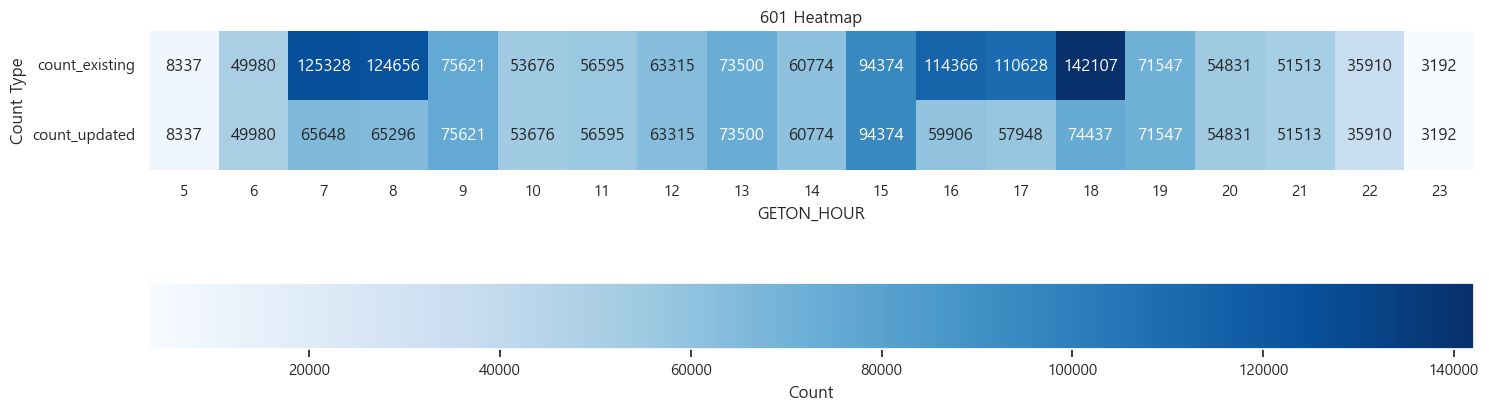

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns
combined_df = pd.merge(sorted_data_df_existing, sorted_data_df_updated, on='GETON_HOUR')

# Set 'GETON_HOUR' as the index of combined_df
combined_df.set_index('GETON_HOUR', inplace=True)

# Transpose the DataFrame to have 'GETON_HOUR' on the x-axis
combined_df = combined_df.transpose()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the heatmap without Seaborn's colorbar (cbar=False)
heatmap = sns.heatmap(combined_df, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)

# Add a label to the colorbar
cbar = heatmap.figure.colorbar(heatmap.collections[0], orientation='horizontal', pad=0.2)
cbar.set_label('Count')
cbar.ax.set_position([0.1, 0.2, 0.6, 0.01])
plt.title('601 Heatmap')
plt.xlabel('GETON_HOUR')
plt.ylabel('Count Type')

plt.tight_layout()
plt.show()


704

In [40]:
found_combinations = []

# 203, 613, 511 3가지 조합
for cost_203 in BUS_203_COST['DECREASE_IN_BUS'].to_list():
    for cost_613 in BUS_613_COST['DECREASE_IN_BUS'].to_list():
        for cost_511 in BUS_511_COST['DECREASE_IN_BUS'].to_list():
            total_cost = cost_203 + cost_613 + cost_511
            if total_cost in BUS_704_COST['INCREASE_IN_BUS'].to_list():
                found_combinations.append((cost_203, cost_613, cost_511, total_cost))

# 203, 613 2가지 조합
for cost_203 in BUS_203_COST['DECREASE_IN_BUS'].to_list():
    for cost_613 in BUS_613_COST['DECREASE_IN_BUS'].to_list():
        total_cost = cost_203 + cost_613
        if total_cost in BUS_704_COST['INCREASE_IN_BUS'].to_list():
            found_combinations.append((cost_203, cost_613, None, total_cost))

# 203, 511 2가지 조합
for cost_203 in BUS_203_COST['DECREASE_IN_BUS'].to_list():
    for cost_511 in BUS_511_COST['DECREASE_IN_BUS'].to_list():
        total_cost = cost_203 + cost_511
        if total_cost in BUS_704_COST['INCREASE_IN_BUS'].to_list():
            found_combinations.append((cost_203, None, cost_511, total_cost))

# 613, 511 2가지 조합
for cost_613 in BUS_613_COST['DECREASE_IN_BUS'].to_list():
    for cost_511 in BUS_511_COST['DECREASE_IN_BUS'].to_list():
        total_cost = cost_613 + cost_511
        if total_cost in BUS_704_COST['INCREASE_IN_BUS'].to_list():
            found_combinations.append((None, cost_613, cost_511, total_cost))

# 203 1가지 조합
for cost_203 in BUS_203_COST['DECREASE_IN_BUS'].to_list():
    total_cost = cost_203
    if total_cost in BUS_704_COST['INCREASE_IN_BUS'].to_list():
        found_combinations.append((cost_203, None, None, total_cost))

# 613 1가지 조합
for cost_613 in BUS_613_COST['DECREASE_IN_BUS'].to_list():
    total_cost = cost_613
    if total_cost in BUS_704_COST['INCREASE_IN_BUS'].to_list():
        found_combinations.append((None, cost_613, None, total_cost))

# 511 1가지 조합
for cost_511 in BUS_511_COST['DECREASE_IN_BUS'].to_list():
    total_cost = cost_511
    if total_cost in BUS_704_COST['INCREASE_IN_BUS'].to_list():
        found_combinations.append((None, None, cost_511, total_cost))

if found_combinations:
    print("합이 INCREASE_IN_BUS_704의 각 원소와 일치하는 조합:")
    for idx, (cost_203, cost_613, cost_511, total_cost) in enumerate(found_combinations, start=1):
        combo_str = ""
        if cost_203 is not None:
            combo_str += f"BUS_203_COST['DECREASE_IN_BUS'][{cost_203}]"
        if cost_613 is not None:
            if combo_str:
                combo_str += ", "
            combo_str += f"BUS_613_COST['DECREASE_IN_BUS'][{cost_613}]"
        if cost_511 is not None:
            if combo_str:
                combo_str += ", "
            combo_str += f"BUS_511_COST['DECREASE_IN_BUS'][{cost_511}]"

        # 변경된 대기시간 비용 합 계산
        changed_waiting_time_cost_sum = 0

        if cost_203 is not None:
            rows = BUS_203_COST[BUS_203_COST['DECREASE_IN_BUS'] == cost_203]['LOSS']
            if not rows.empty:
                changed_waiting_time_cost_sum += rows.values[0]

        if cost_613 is not None:
            rows = BUS_613_COST[BUS_613_COST['DECREASE_IN_BUS'] == cost_613]['LOSS']
            if not rows.empty:
                changed_waiting_time_cost_sum += rows.values[0]

        if cost_511 is not None:
            rows = BUS_511_COST[BUS_511_COST['DECREASE_IN_BUS'] == cost_511]['LOSS']
            if not rows.empty:
                changed_waiting_time_cost_sum += rows.values[0]

        rows = BUS_704_COST[BUS_704_COST['INCREASE_IN_BUS'] == total_cost]['PROFIT']
        if not rows.empty:
            changed_waiting_time_cost_sum += rows.values[0]

        print(f"{idx}. 조합: ({combo_str}), BUS_704의 증차 대수: {total_cost}, 변경된 대기시간 비용 합: {changed_waiting_time_cost_sum}")
else:
    print("일치하는 조합을 찾지 못했습니다.")



합이 INCREASE_IN_BUS_704의 각 원소와 일치하는 조합:
1. 조합: (BUS_203_COST['DECREASE_IN_BUS'][13], BUS_613_COST['DECREASE_IN_BUS'][18], BUS_511_COST['DECREASE_IN_BUS'][11]), BUS_704의 증차 대수: 42, 변경된 대기시간 비용 합: 368574
2. 조합: (BUS_203_COST['DECREASE_IN_BUS'][6], BUS_613_COST['DECREASE_IN_BUS'][18]), BUS_704의 증차 대수: 24, 변경된 대기시간 비용 합: 289907
3. 조합: (BUS_203_COST['DECREASE_IN_BUS'][13], BUS_511_COST['DECREASE_IN_BUS'][11]), BUS_704의 증차 대수: 24, 변경된 대기시간 비용 합: 296627
4. 조합: (BUS_613_COST['DECREASE_IN_BUS'][18]), BUS_704의 증차 대수: 18, 변경된 대기시간 비용 합: 240508


---
나머지 히트맵 그리기

**조합: (BUS_912_COST['DECREASE_IN_BUS'][15], BUS_117_COST['DECREASE_IN_BUS'][5], BUS_701_COST['DECREASE_IN_BUS'][6]), BUS_601의 증차 대수: 26, 변경된 대기시간 비용 합: 227142**

In [41]:
# 601
# 데이터를 시간대순으로 정렬
sorted_data_existing_601 = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_601 = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_601 = sorted_data_existing_601 * (21//2)

# 데이터프레임 생성
sorted_data_df_existing_601 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_601.index, 'count_existing_601': sorted_data_existing_601.values})
sorted_data_df_updated_601 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_601.index, 'count_updated_601': sorted_data_updated_601.values})

# 조건에 따라 count_updated 열 수정
sorted_data_df_updated_601['count_updated_601'] = sorted_data_df_updated_601.apply(
    lambda row: row['count_updated_601'] * (11//2) if row['GETON_HOUR'] in [7, 8, 16, 17, 18] else row['count_updated_601'] * (21//2),
    axis=1
)

# 두 데이터프레임을 하나로 결합
combined_df_601 = pd.merge(sorted_data_df_existing_601, sorted_data_df_updated_601, on='GETON_HOUR')

# 912
# 데이터를 시간대순으로 정렬
sorted_data_existing_912 = BUS_912_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_912 = BUS_912_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_912 = sorted_data_existing_912 * (19//2)
sorted_data_updated_912 = sorted_data_updated_912 * (22//2)

# 데이터프레임 생성
sorted_data_df_existing_912 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_912.index, 'count_existing_912': sorted_data_existing_912.values})
sorted_data_df_updated_912 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_912.index, 'count_updated_912': sorted_data_updated_912.values})

# 두 데이터프레임을 하나로 결합
combined_df_912 = pd.merge(sorted_data_df_existing_912, sorted_data_df_updated_912, on='GETON_HOUR')

# 117
# 데이터를 시간대순으로 정렬
sorted_data_existing_117 = BUS_117_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_117 = BUS_117_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_117 = sorted_data_existing_117 * (20//2)
sorted_data_updated_117 = sorted_data_updated_117 * (21//2)

# 데이터프레임 생성
sorted_data_df_existing_117 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_117.index, 'count_existing_117': sorted_data_existing_117.values})
sorted_data_df_updated_117 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_117.index, 'count_updated_117': sorted_data_updated_117.values})

# 두 데이터프레임을 하나로 결합
combined_df_117 = pd.merge(sorted_data_df_existing_117, sorted_data_df_updated_117, on='GETON_HOUR')


# 701
# 데이터를 시간대순으로 정렬
sorted_data_existing_701 = BUS_701_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_701 = BUS_701_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_701 = sorted_data_existing_701 * (18//2)
sorted_data_updated_701 = sorted_data_updated_701 * (19//2)

# 데이터프레임 생성
sorted_data_df_existing_701 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_701.index, 'count_existing_701': sorted_data_existing_701.values})
sorted_data_df_updated_701 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_701.index, 'count_updated_701': sorted_data_updated_701.values})

# 두 데이터프레임을 하나로 결합
combined_df_701 = pd.merge(sorted_data_df_existing_701, sorted_data_df_updated_701, on='GETON_HOUR')

In [47]:
from functools import reduce

# 병합할 데이터프레임들을 리스트로 묶기
dataframes_to_merge = [combined_df_601, combined_df_912, combined_df_117,combined_df_701]

# 데이터프레임을 순차적으로 병합
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GETON_HOUR'), dataframes_to_merge)

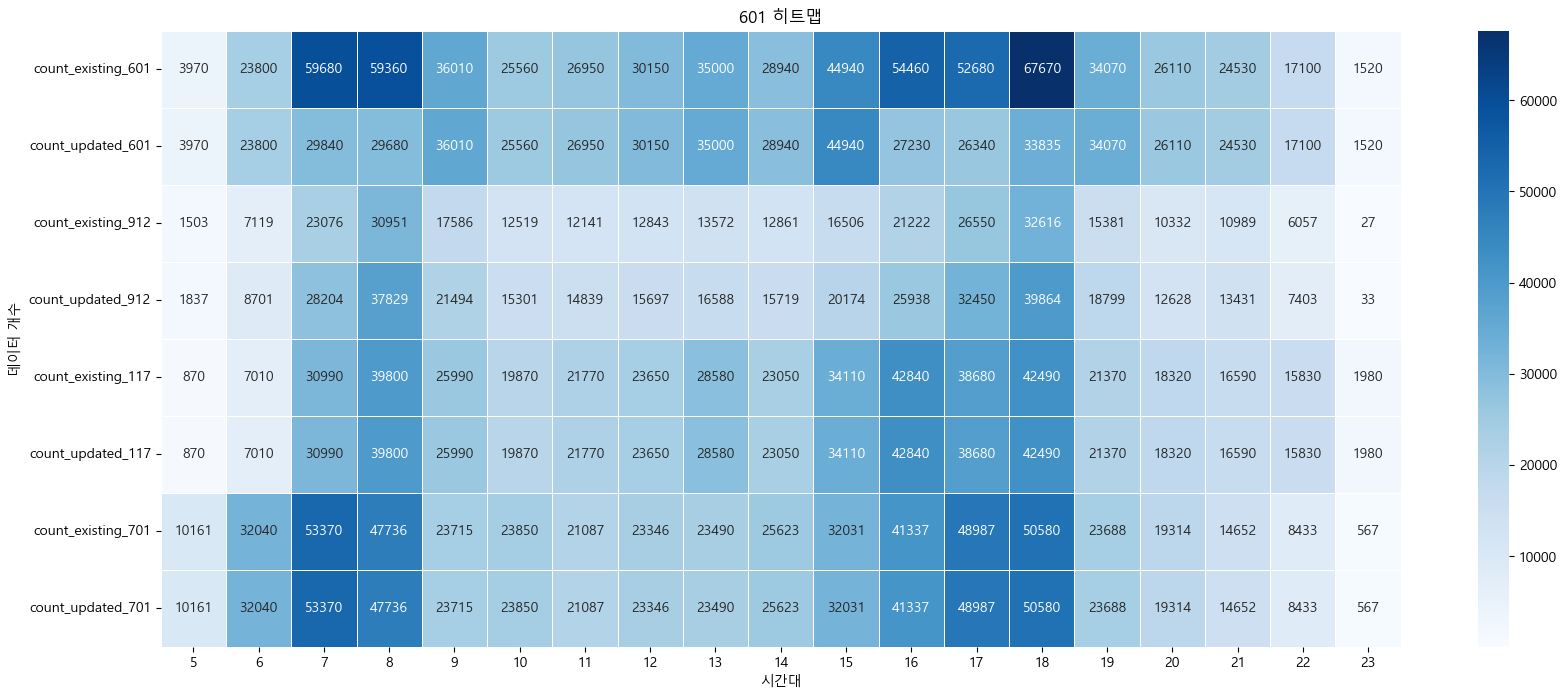

In [48]:
# 데이터프레임 재구성
heatmap_data = merged_df.set_index('GETON_HOUR')
heatmap_data = heatmap_data.transpose()

# 히트맵 그리기
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', linewidths=.5)
plt.xlabel('시간대')
plt.ylabel('데이터 개수')
plt.title('601 히트맵')
plt.show()

**조합: (BUS_203_COST['DECREASE_IN_BUS'][13], BUS_511_COST['DECREASE_IN_BUS'][11]), BUS_704의 증차 대수: 24, 변경된 대기시간 비용 합: 296627**

In [44]:
# 704
# 데이터를 시간대순으로 정렬
sorted_data_existing_704 = BUS_704_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_704 = BUS_704_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_704 = sorted_data_existing_704 * (14//2)

# 데이터프레임 생성
sorted_data_df_existing_704 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_704.index, 'count_existing_704': sorted_data_existing_704.values})
sorted_data_df_updated_704 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_704.index, 'count_updated_704': sorted_data_updated_704.values})

# 조건에 따라 count_updated 열 수정
sorted_data_df_updated_704['count_updated_704'] = sorted_data_df_updated_704.apply(
    lambda row: row['count_updated_704'] * (9//2) if row['GETON_HOUR'] in [7, 8, 16, 17, 18] else row['count_updated_704'] * (14//2),
    axis=1
)

# 두 데이터프레임을 하나로 결합
combined_df_704 = pd.merge(sorted_data_df_existing_704, sorted_data_df_updated_704, on='GETON_HOUR')

# 203
# 데이터를 시간대순으로 정렬
sorted_data_existing_203 = BUS_203_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_203 = BUS_203_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_203 = sorted_data_existing_203 * (16//2)
sorted_data_updated_203 = sorted_data_updated_203 * (18//2)

# 데이터프레임 생성
sorted_data_df_existing_203 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_203.index, 'count_existing_203': sorted_data_existing_203.values})
sorted_data_df_updated_203 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_203.index, 'count_updated_203': sorted_data_updated_203.values})

# 두 데이터프레임을 하나로 결합
combined_df_203 = pd.merge(sorted_data_df_existing_203, sorted_data_df_updated_203, on='GETON_HOUR')

# 511
# 데이터를 시간대순으로 정렬
sorted_data_existing_511 = BUS_511_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_511 = BUS_511_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_511 = sorted_data_existing_511 * (13//2)
sorted_data_updated_511 = sorted_data_updated_511 * (14//2)

# 데이터프레임 생성
sorted_data_df_existing_511 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_511.index, 'count_existing_511': sorted_data_existing_511.values})
sorted_data_df_updated_511 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_511.index, 'count_updated_511': sorted_data_updated_511.values})

# 두 데이터프레임을 하나로 결합
combined_df_511 = pd.merge(sorted_data_df_existing_511, sorted_data_df_updated_511, on='GETON_HOUR')

In [45]:
from functools import reduce

# 병합할 데이터프레임들을 리스트로 묶기
dataframes_to_merge = [combined_df_704, combined_df_203, combined_df_511]

# 데이터프레임을 순차적으로 병합
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GETON_HOUR'), dataframes_to_merge)

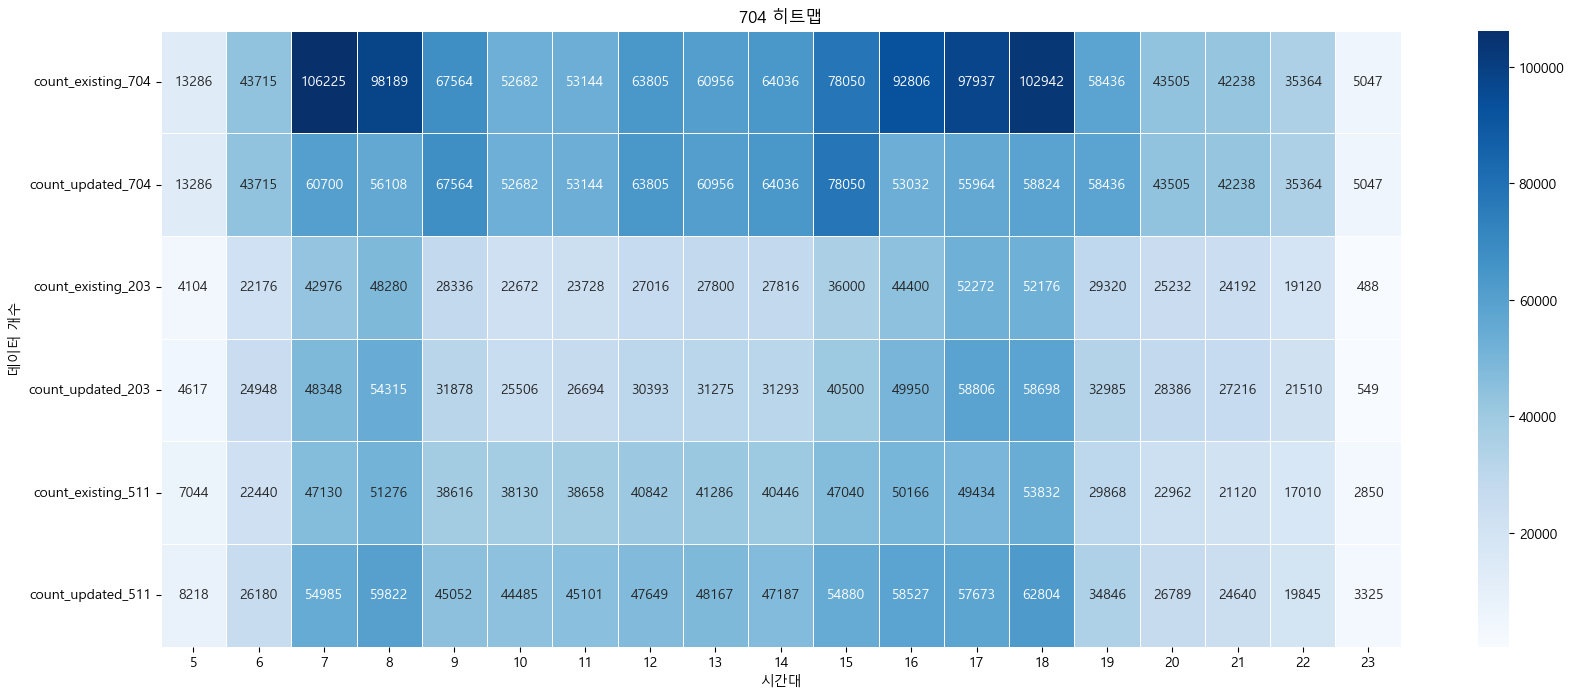

In [46]:
# 데이터프레임 재구성
heatmap_data = merged_df.set_index('GETON_HOUR')
heatmap_data = heatmap_data.transpose()

# 히트맵 그리기
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', linewidths=.5)
plt.xlabel('시간대')
plt.ylabel('데이터 개수')
plt.title('704 히트맵')
plt.show()

---

**조합: (BUS_912_COST['DECREASE_IN_BUS'][22], BUS_117_COST['DECREASE_IN_BUS'][10]), BUS_601의 증차 대수: 32, 변경된 대기시간 비용 합: 234649**

In [55]:
# 601
# 데이터를 시간대순으로 정렬
sorted_data_existing_601 = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_601 = BUS_601_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_601 = sorted_data_existing_601 * (21//2)

# 데이터프레임 생성
sorted_data_df_existing_601 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_601.index, 'count_existing_601': sorted_data_existing_601.values})
sorted_data_df_updated_601 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_601.index, 'count_updated_601': sorted_data_updated_601.values})

# 조건에 따라 count_updated 열 수정
sorted_data_df_updated_601['count_updated_601'] = sorted_data_df_updated_601.apply(
    lambda row: row['count_updated_601'] * (11//2) if row['GETON_HOUR'] in [7, 8, 16, 17, 18] else row['count_updated_601'] * (21//2),
    axis=1
)

# 두 데이터프레임을 하나로 결합
combined_df_601 = pd.merge(sorted_data_df_existing_601, sorted_data_df_updated_601, on='GETON_HOUR')

# 912
# 데이터를 시간대순으로 정렬
sorted_data_existing_912 = BUS_912_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_912 = BUS_912_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_912 = sorted_data_existing_912 * (19//2)
sorted_data_updated_912 = sorted_data_updated_912 * (22//2)

# 데이터프레임 생성
sorted_data_df_existing_912 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_912.index, 'count_existing_912': sorted_data_existing_912.values})
sorted_data_df_updated_912 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_912.index, 'count_updated_912': sorted_data_updated_912.values})

# 두 데이터프레임을 하나로 결합
combined_df_912 = pd.merge(sorted_data_df_existing_912, sorted_data_df_updated_912, on='GETON_HOUR')

# 117
# 데이터를 시간대순으로 정렬
sorted_data_existing_117 = BUS_117_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_117 = BUS_117_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_117 = sorted_data_existing_117 * (20//2)
sorted_data_updated_117 = sorted_data_updated_117 * (21/2)
sorted_data_updated_117=sorted_data_updated_117.astype(int)
# 데이터프레임 생성
sorted_data_df_existing_117 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_117.index, 'count_existing_117': sorted_data_existing_117.values})
sorted_data_df_updated_117 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_117.index, 'count_updated_117': sorted_data_updated_117.values})

# 두 데이터프레임을 하나로 결합
combined_df_117 = pd.merge(sorted_data_df_existing_117, sorted_data_df_updated_117, on='GETON_HOUR')

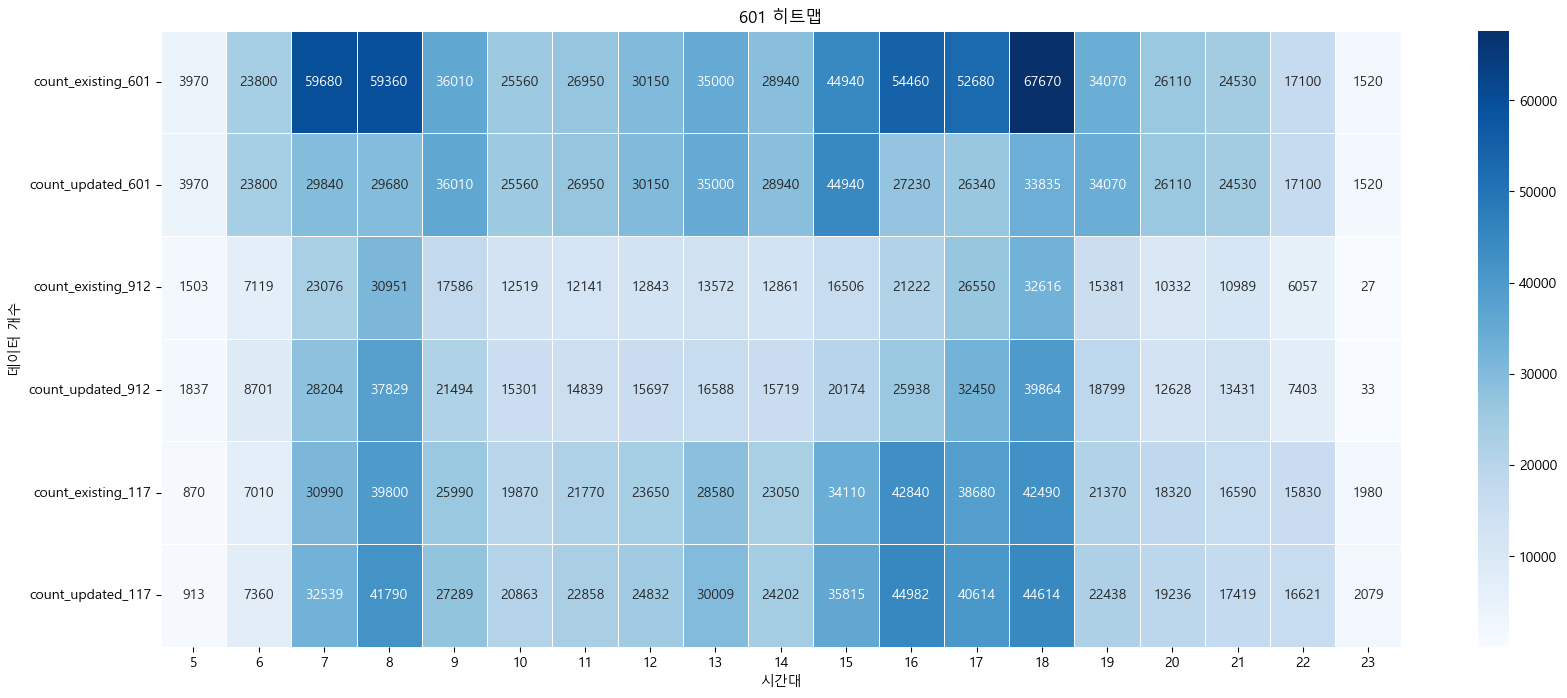

In [56]:
from functools import reduce

# 병합할 데이터프레임들을 리스트로 묶기
dataframes_to_merge = [combined_df_601, combined_df_912, combined_df_117]

# 데이터프레임을 순차적으로 병합
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GETON_HOUR'), dataframes_to_merge)

# 데이터프레임 재구성
heatmap_data = merged_df.set_index('GETON_HOUR')
heatmap_data = heatmap_data.transpose()

# 히트맵 그리기
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', linewidths=.5)
plt.xlabel('시간대')
plt.ylabel('데이터 개수')
plt.title('601 히트맵')
plt.show()

**조합: (BUS_203_COST['DECREASE_IN_BUS'][13], BUS_613_COST['DECREASE_IN_BUS'][18], BUS_511_COST['DECREASE_IN_BUS'][11]), BUS_704의 증차 대수: 42, 변경된 대기시간 비용 합: 368574**

In [57]:
# 704
# 데이터를 시간대순으로 정렬
sorted_data_existing_704 = BUS_704_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_704 = BUS_704_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_704 = sorted_data_existing_704 * (14//2)

# 데이터프레임 생성
sorted_data_df_existing_704 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_704.index, 'count_existing_704': sorted_data_existing_704.values})
sorted_data_df_updated_704 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_704.index, 'count_updated_704': sorted_data_updated_704.values})

# 조건에 따라 count_updated 열 수정
sorted_data_df_updated_704['count_updated_704'] = sorted_data_df_updated_704.apply(
    lambda row: row['count_updated_704'] * (7//2) if row['GETON_HOUR'] in [7, 8, 16, 17, 18] else row['count_updated_704'] * (14//2),
    axis=1
)

# 두 데이터프레임을 하나로 결합
combined_df_704 = pd.merge(sorted_data_df_existing_704, sorted_data_df_updated_704, on='GETON_HOUR')

# 203
# 데이터를 시간대순으로 정렬
sorted_data_existing_203 = BUS_203_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_203 = BUS_203_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_203 = sorted_data_existing_203 * (16//2)
sorted_data_updated_203 = sorted_data_updated_203 * (18//2)

# 데이터프레임 생성
sorted_data_df_existing_203 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_203.index, 'count_existing_203': sorted_data_existing_203.values})
sorted_data_df_updated_203 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_203.index, 'count_updated_203': sorted_data_updated_203.values})

# 두 데이터프레임을 하나로 결합
combined_df_203 = pd.merge(sorted_data_df_existing_203, sorted_data_df_updated_203, on='GETON_HOUR')

# 613
# 데이터를 시간대순으로 정렬
sorted_data_existing_613 = BUS_613_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_613 = BUS_613_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_613 = sorted_data_existing_613 * (14//2)
sorted_data_updated_613 = sorted_data_updated_613 * (16//2)

# 데이터프레임 생성
sorted_data_df_existing_613 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_613.index, 'count_existing_613': sorted_data_existing_613.values})
sorted_data_df_updated_613 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_613.index, 'count_updated_613': sorted_data_updated_613.values})

# 두 데이터프레임을 하나로 결합
combined_df_613 = pd.merge(sorted_data_df_existing_613, sorted_data_df_updated_613, on='GETON_HOUR')

# 511
# 데이터를 시간대순으로 정렬
sorted_data_existing_511 = BUS_511_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_updated_511 = BUS_511_MERGE['GETON_HOUR'].value_counts().sort_index()
sorted_data_existing_511 = sorted_data_existing_511 * (13//2)
sorted_data_updated_511 = sorted_data_updated_511 * (14//2)

# 데이터프레임 생성
sorted_data_df_existing_511 = pd.DataFrame({'GETON_HOUR': sorted_data_existing_511.index, 'count_existing_511': sorted_data_existing_511.values})
sorted_data_df_updated_511 = pd.DataFrame({'GETON_HOUR': sorted_data_updated_511.index, 'count_updated_511': sorted_data_updated_511.values})

# 두 데이터프레임을 하나로 결합
combined_df_511 = pd.merge(sorted_data_df_existing_511, sorted_data_df_updated_511, on='GETON_HOUR')

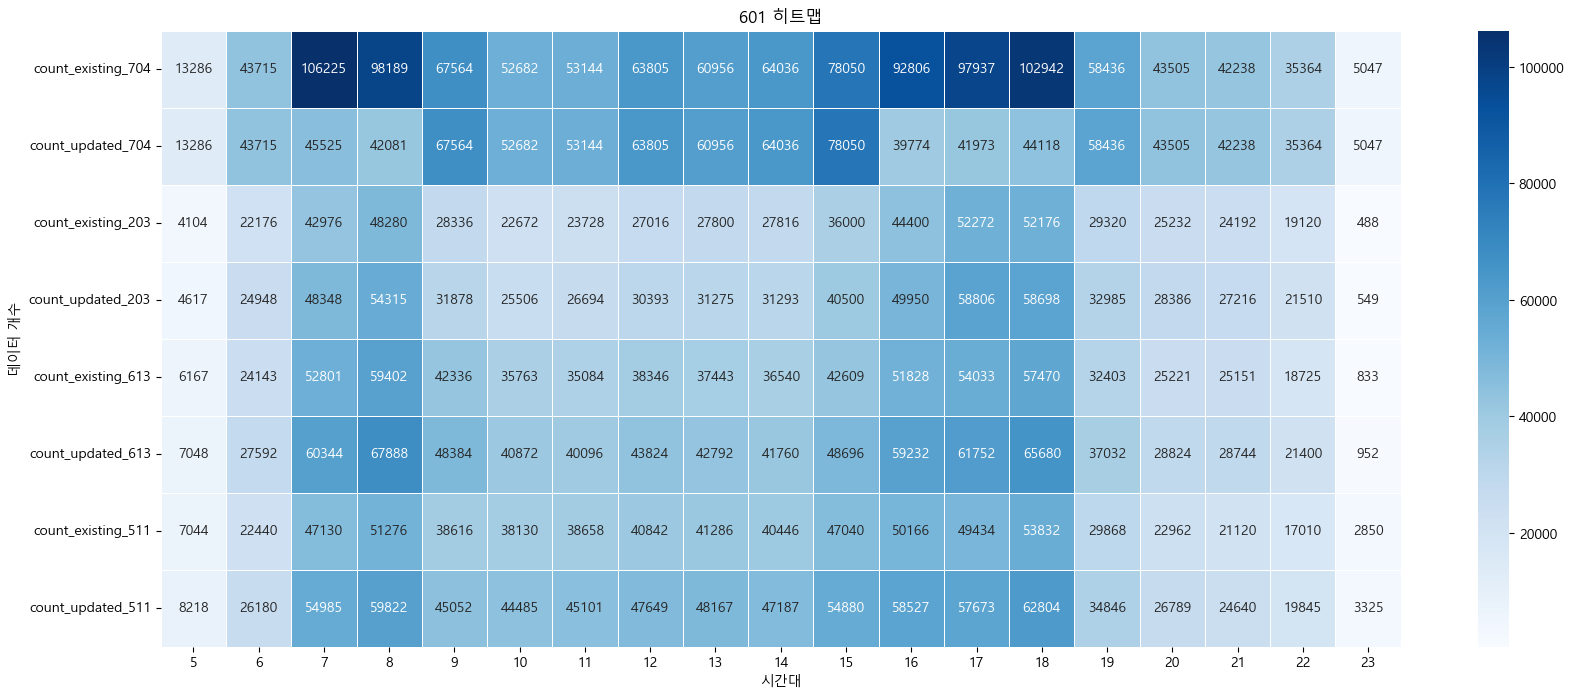

In [58]:
from functools import reduce

# 병합할 데이터프레임들을 리스트로 묶기
dataframes_to_merge = [combined_df_704,combined_df_203, combined_df_613, combined_df_511]

# 데이터프레임을 순차적으로 병합
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GETON_HOUR'), dataframes_to_merge)

# 데이터프레임 재구성
heatmap_data = merged_df.set_index('GETON_HOUR')
heatmap_data = heatmap_data.transpose()

# 히트맵 그리기
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', linewidths=.5)
plt.xlabel('시간대')
plt.ylabel('데이터 개수')
plt.title('601 히트맵')
plt.show()